# SASA (Solvent Accessible Surface Area) Analysis with abagpdb

This notebook demonstrates how to **analyze solvent accessible surface area** and identify interface residues using the `abagpdb` package.

## Overview

SASA analysis helps you:
- **Quantify exposed surface**: Measure accessible surface area of proteins
- **Identify interface residues**: Find residues buried upon binding
- **Calculate binding interfaces**: Quantify buried surface area (BSA)
- **Compare bound vs unbound states**: Track surface changes
- **Characterize interaction sites**: Understand molecular recognition

## Key Concepts

| Term | Definition | Application |
|------|------------|-------------|
| **SASA** | Solvent Accessible Surface Area | Total surface accessible to solvent |
| **Unbound SASA** | SASA when chain is isolated | Chain in solution alone |
| **Bound SASA** | SASA when in complex | Chain in the complex |
| **ΔSASA** | Unbound - Bound | Surface buried upon binding |
| **Burial Fraction** | ΔSASA / Unbound | Fraction of surface buried (0-1) |
| **BSA** | Buried Surface Area | Total surface buried in interface |

---

## Example: Antibody-Antigen Complex (PDB: 5GGS)

## 1. Setup and Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from abagpdb.pdbparser import parse_pdb
from abagpdb.sasa_analysis import (
    per_residue_sasa,
    per_atom_sasa,
    compare_bound_unbound_sasa,
    identify_interface_residues,
    summarize_sasa_by_chain,
    print_sasa_report,
    export_sasa_results
)

## 2. Load PDB Structure

In [2]:
# Parse the PDB file
cx = parse_pdb("5GGS_wt.pdb")

print("✓ Structure loaded successfully!")
print(f"  File: {cx.source_path}")
print(f"  Chains: {', '.join(cx.chains.keys())}")

# Count residues per chain
print(f"\nResidue counts:")
for chain_id, chain in cx.chains.items():
    n_residues = len(chain.residues)
    print(f"  Chain {chain_id}: {n_residues} residues")

✓ Structure loaded successfully!
  File: 5GGS_wt.pdb
  Chains: A, H, L

Residue counts:
  Chain A: 113 residues
  Chain H: 219 residues
  Chain L: 217 residues


## 3. Simple Per-Residue SASA

Calculate SASA for residues in a selection (residues occlude each other within selection).

In [3]:
# Calculate SASA for chain A alone
sasa_chain_a = per_residue_sasa(
    cx,
    exprs="A",
    probe=1.4,      # Water probe radius (Å)
    n_points=200,   # Sampling points for accuracy
    algorithm="lr", # Lee-Richards (more accurate) or "sr" (Shrake-Rupley, faster)
    ignore_h=True   # Ignore hydrogen atoms
)

print("=" * 80)
print("PER-RESIDUE SASA FOR CHAIN A".center(80))
print("=" * 80)
print(f"Residues analyzed: {len(sasa_chain_a)}")

# Sort by SASA (most exposed first)
sorted_sasa = sorted(sasa_chain_a.items(), key=lambda x: x[1], reverse=True)

print(f"\nTop 10 most exposed residues:")
print(f"{'Rank':<6}{'Residue':<20}{'SASA (Ų)':<15}")
print("-" * 80)

for i, (res_id, sasa_val) in enumerate(sorted_sasa[:10], 1):
    print(f"{i:<6}{res_id:<20}{sasa_val:<15.2f}")

# Statistics
sasa_values = list(sasa_chain_a.values())
print(f"\nSASA Statistics:")
print(f"  Total SASA: {sum(sasa_values):.1f} Ų")
print(f"  Mean:       {np.mean(sasa_values):.1f} Ų")
print(f"  Median:     {np.median(sasa_values):.1f} Ų")
print(f"  Max:        {max(sasa_values):.1f} Ų")

print("=" * 80)

                          PER-RESIDUE SASA FOR CHAIN A                          
Residues analyzed: 113

Top 10 most exposed residues:
Rank  Residue             SASA (Ų)       
--------------------------------------------------------------------------------
1     ARG A:85            204.15         
2     ARG A:56            185.30         
3     LYS A:101           173.62         
4     PRO A:1             164.58         
5     LEU A:108           158.25         
6     PRO A:42            150.93         
7     PRO A:71            141.05         
8     GLU A:16            140.04         
9     ARG A:84            124.55         
10    PRO A:59            124.11         

SASA Statistics:
  Total SASA: 6800.3 Ų
  Mean:       60.2 Ų
  Median:     56.7 Ų
  Max:        204.1 Ų


## 4. Bound vs Unbound SASA Comparison

**KEY ANALYSIS**: Compare SASA when chains are isolated vs in complex.

In [4]:
# Compare antibody (H+L) and antigen (A) in bound vs unbound states
sasa_results = compare_bound_unbound_sasa(
    cx,
    chain_exprs=["H", "L", "A"],  # Analyze each chain separately then together
    probe=1.4,
    n_points=200,
    algorithm="lr",
    ignore_h=True
)

print("=" * 80)
print("BOUND VS UNBOUND SASA ANALYSIS COMPLETE".center(80))
print("=" * 80)
print(f"Total residues analyzed: {len(sasa_results)}")

# Calculate summary statistics
total_buried = sum(r['delta'] for r in sasa_results.values())
interface_residues = sum(1 for r in sasa_results.values() if r['buried_fraction'] >= 0.5)

print(f"\nSummary:")
print(f"  Total buried surface area (BSA): {total_buried:.1f} Ų")
print(f"  Interface residues (≥50% burial): {interface_residues}")
print(f"  Average burial fraction: {np.mean([r['buried_fraction'] for r in sasa_results.values()]) * 100:.1f}%")

print("=" * 80)

                    BOUND VS UNBOUND SASA ANALYSIS COMPLETE                     
Total residues analyzed: 549

Summary:
  Total buried surface area (BSA): 5929.3 Ų
  Interface residues (≥50% burial): 92
  Average burial fraction: 16.7%


### Sample Results for Top Buried Residues

In [5]:
# Sort by burial amount (ΔSASA)
sorted_by_burial = sorted(
    sasa_results.items(),
    key=lambda x: x[1]['delta'],
    reverse=True
)

print("=" * 100)
print("TOP 20 RESIDUES BY BURIED SURFACE AREA (ΔSASA)".center(100))
print("=" * 100)
print(f"{'Rank':<6}{'Residue':<15}{'Unbound (Ų)':<15}{'Bound (Ų)':<15}{'ΔSASA (Ų)':<15}{'Burial %':<15}")
print("-" * 100)

for i, (res_id, values) in enumerate(sorted_by_burial[:20], 1):
    print(f"{i:<6}{res_id:<15}{values['unbound']:<15.1f}{values['bound']:<15.1f}"
          f"{values['delta']:<15.1f}{values['buried_fraction']*100:<15.1f}")

print("=" * 100)

                           TOP 20 RESIDUES BY BURIED SURFACE AREA (ΔSASA)                           
Rank  Residue        Unbound (Ų)    Bound (Ų)      ΔSASA (Ų)      Burial %       
----------------------------------------------------------------------------------------------------
1     PHE H:102      150.0          2.3            147.7          98.5           
2     ARG H:101      167.7          28.3           139.4          83.1           
3     LYS A:101      173.6          34.7           138.9          80.0           
4     LYS H:135      194.4          61.8           132.7          68.2           
5     PRO A:59       124.1          0.0            124.1          100.0          
6     ARG A:56       185.3          61.8           123.5          66.7           
7     MET H:104      116.0          0.7            115.3          99.4           
8     TYR L:34       129.6          20.2           109.4          84.4           
9     PHE L:102      122.7          19.1           103.5    

## 5. Identify Interface Residues

Find residues that become significantly buried upon binding.

In [6]:
# Identify interface residues with strict criteria
interface = identify_interface_residues(
    sasa_results,
    burial_threshold=0.5,  # ≥50% burial
    min_delta_sasa=10.0    # ≥10 Ų buried
)

print("=" * 80)
print(f"INTERFACE RESIDUES (≥50% burial AND ≥10 Ų buried)".center(80))
print("=" * 80)
print(f"Total interface residues: {len(interface)}")

# Group by chain
chain_interface = {}
for res_id, burial_frac, delta in interface:
    # Extract chain from residue ID
    chain = res_id.split(':')[0].split()[-1] if ':' in res_id else res_id.split()[1][0]
    if chain not in chain_interface:
        chain_interface[chain] = []
    chain_interface[chain].append((res_id, burial_frac, delta))

print(f"\nInterface residues per chain:")
for chain, residues in sorted(chain_interface.items()):
    print(f"  Chain {chain}: {len(residues)} residues")

# Show top 10 from each chain
for chain, residues in sorted(chain_interface.items()):
    print(f"\nTop 10 interface residues in chain {chain}:")
    print(f"{'Rank':<6}{'Residue':<20}{'Burial %':<15}{'ΔSASA (Ų)':<15}")
    print("-" * 80)
    
    for i, (res_id, burial_frac, delta) in enumerate(residues[:10], 1):
        print(f"{i:<6}{res_id:<20}{burial_frac*100:<15.1f}{delta:<15.1f}")

print("=" * 80)

               INTERFACE RESIDUES (≥50% burial AND ≥10 Ų buried)                
Total interface residues: 83

Interface residues per chain:
  Chain A: 15 residues
  Chain H: 35 residues
  Chain L: 33 residues

Top 10 interface residues in chain A:
Rank  Residue             Burial %       ΔSASA (Ų)      
--------------------------------------------------------------------------------
1     ILE A:96            100.0          25.0           
2     PRO A:59            100.0          124.1          
3     LEU A:98            99.7           92.9           
4     ASN A:36            99.2           17.1           
5     TYR A:38            98.2           16.7           
6     SER A:57            96.8           98.0           
7     VAL A:34            95.7           32.2           
8     PRO A:53            94.7           73.0           
9     ASP A:55            85.9           37.1           
10    LYS A:101           80.0           138.9          

Top 10 interface residues in chain H:
Rank

## 6. Chain-Level Summary

Summarize SASA statistics by chain.

In [7]:
# Get chain-level statistics
chain_summary = summarize_sasa_by_chain(sasa_results)

print("=" * 100)
print("CHAIN-LEVEL SASA SUMMARY".center(100))
print("=" * 100)
print(f"{'Chain':<8}{'#Res':<10}{'Unbound (Ų)':<15}{'Bound (Ų)':<15}{'Buried (Ų)':<15}"
      f"{'Interface':<12}{'Avg Burial':<15}")
print("-" * 100)

for chain_id, stats in sorted(chain_summary.items()):
    print(f"{chain_id:<8}{int(stats['num_residues']):<10}"
          f"{stats['total_unbound']:<15.1f}{stats['total_bound']:<15.1f}"
          f"{stats['total_buried']:<15.1f}{int(stats['interface_residues']):<12}"
          f"{stats['avg_burial_fraction']*100:<15.1f}%")

print("=" * 100)

# Interpretation
print("\nInterpretation:")
print("  • Unbound: SASA when chain is isolated")
print("  • Bound: SASA when in complex")
print("  • Buried: Surface area buried upon binding (interface size)")
print("  • Interface: Number of residues with ≥50% burial")
print("  • Avg Burial: Average burial fraction across all residues")

                                      CHAIN-LEVEL SASA SUMMARY                                      
Chain   #Res      Unbound (Ų)    Bound (Ų)      Buried (Ų)     Interface   Avg Burial     
----------------------------------------------------------------------------------------------------
A       113       6800.3         5661.3         1139.0         16          14.4           %
H       219       11498.5        8993.3         2505.2         41          18.2           %
L       217       11718.2        9433.2         2285.0         35          16.5           %

Interpretation:
  • Unbound: SASA when chain is isolated
  • Bound: SASA when in complex
  • Buried: Surface area buried upon binding (interface size)
  • Interface: Number of residues with ≥50% burial
  • Avg Burial: Average burial fraction across all residues


## 7. Visualizations

Create visualizations to understand SASA distributions.

### Burial Fraction Distribution

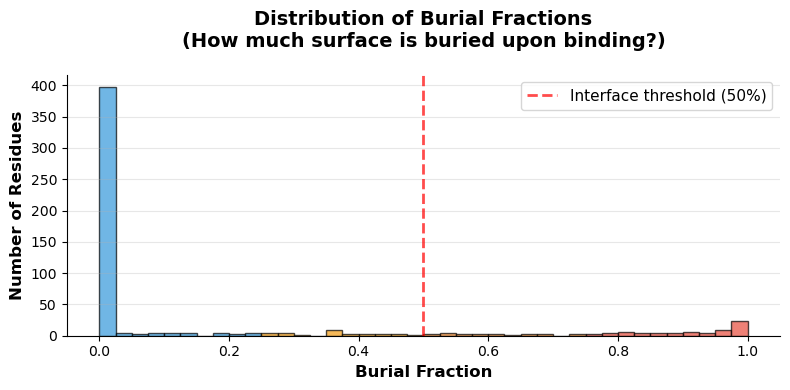


Burial Statistics:
  Highly buried (≥75%):      68 residues
  Moderately buried (50-75%): 24 residues
  Slightly buried (25-50%):   29 residues
  Exposed (<25%):            428 residues


In [9]:
# Extract burial fractions
burial_fractions = [values['buried_fraction'] for values in sasa_results.values()]

# Create histogram
fig, ax = plt.subplots(figsize=(8, 4))

n, bins, patches = ax.hist(burial_fractions, bins=40, edgecolor='black', alpha=0.7)

# Color code by burial level
for i, patch in enumerate(patches):
    bin_center = (bins[i] + bins[i+1]) / 2
    if bin_center >= 0.75:
        patch.set_facecolor('#e74c3c')  # Red: highly buried
    elif bin_center >= 0.50:
        patch.set_facecolor('#e67e22')  # Orange: moderately buried
    elif bin_center >= 0.25:
        patch.set_facecolor('#f39c12')  # Yellow: slightly buried
    else:
        patch.set_facecolor('#3498db')  # Blue: exposed

# Add interface threshold line
ax.axvline(0.5, color='red', linestyle='--', linewidth=2, 
           label='Interface threshold (50%)', alpha=0.7)

ax.set_xlabel('Burial Fraction', fontweight='bold', fontsize=12)
ax.set_ylabel('Number of Residues', fontweight='bold', fontsize=12)
ax.set_title('Distribution of Burial Fractions\n(How much surface is buried upon binding?)', 
             fontweight='bold', fontsize=14, pad=20)
ax.legend(fontsize=11)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Statistics
print(f"\nBurial Statistics:")
print(f"  Highly buried (≥75%):      {sum(1 for b in burial_fractions if b >= 0.75)} residues")
print(f"  Moderately buried (50-75%): {sum(1 for b in burial_fractions if 0.5 <= b < 0.75)} residues")
print(f"  Slightly buried (25-50%):   {sum(1 for b in burial_fractions if 0.25 <= b < 0.5)} residues")
print(f"  Exposed (<25%):            {sum(1 for b in burial_fractions if b < 0.25)} residues")

### Bound vs Unbound SASA for Top Interface Residues

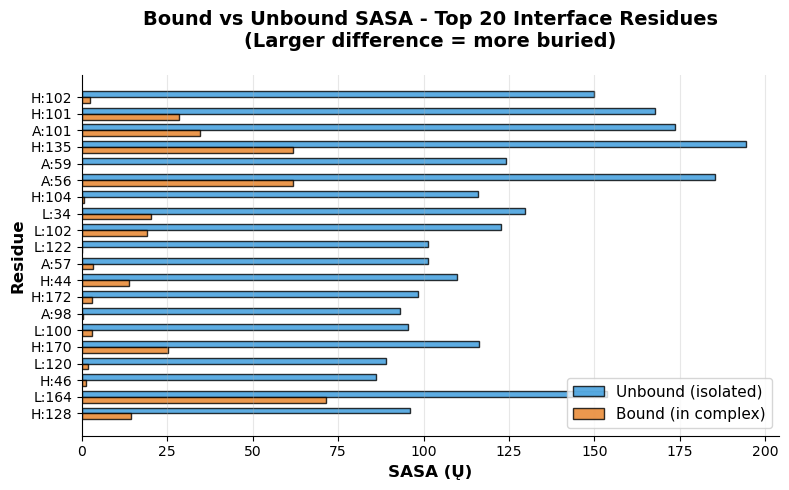

Note: Blue bars (unbound) are longer than orange bars (bound) for interface residues.
      The difference represents the buried surface area (ΔSASA).


In [11]:
# Get top 20 interface residues
top_20 = sorted_by_burial[:20]

# Prepare data
residue_labels = [res_id.split()[-1] for res_id, _ in top_20]  # Short labels
unbound_vals = [values['unbound'] for _, values in top_20]
bound_vals = [values['bound'] for _, values in top_20]

# Create horizontal bar chart
fig, ax = plt.subplots(figsize=(8, 5))

y_pos = np.arange(len(residue_labels))
bar_height = 0.35

ax.barh(y_pos - bar_height/2, unbound_vals, bar_height, 
        label='Unbound (isolated)', color='#3498db', alpha=0.8, edgecolor='black')
ax.barh(y_pos + bar_height/2, bound_vals, bar_height,
        label='Bound (in complex)', color='#e67e22', alpha=0.8, edgecolor='black')

ax.set_yticks(y_pos)
ax.set_yticklabels(residue_labels, fontsize=10)
ax.invert_yaxis()
ax.set_xlabel('SASA (Ų)', fontweight='bold', fontsize=12)
ax.set_ylabel('Residue', fontweight='bold', fontsize=12)
ax.set_title('Bound vs Unbound SASA - Top 20 Interface Residues\n(Larger difference = more buried)', 
             fontweight='bold', fontsize=14, pad=20)
ax.legend(loc='lower right', fontsize=11)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print("Note: Blue bars (unbound) are longer than orange bars (bound) for interface residues.")
print("      The difference represents the buried surface area (ΔSASA).")

### ΔSASA Distribution by Chain

/var/folders/tg/f0jwz81x22s5z6lnwt1nxtn00000gp/T/ipykernel_27608/130616489.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, labels=chains, patch_artist=True,


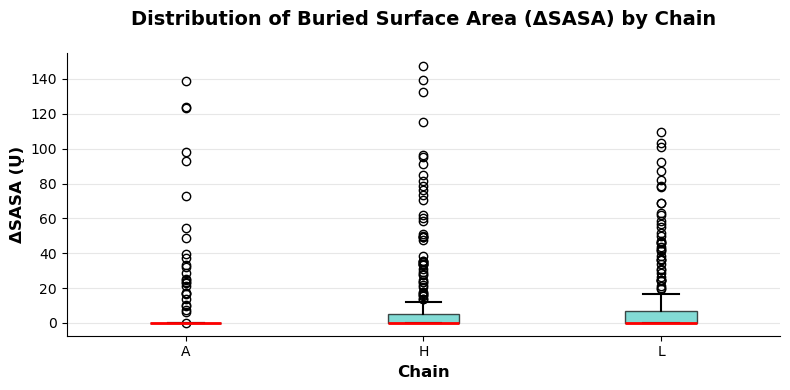


Median ΔSASA per chain:
  Chain A: 0.0 Ų
  Chain H: 0.0 Ų
  Chain L: 0.0 Ų


In [13]:
# Organize ΔSASA by chain
chain_delta_sasa = {}
for res_id, values in sasa_results.items():
    chain = res_id.split(':')[0].split()[-1] if ':' in res_id else res_id.split()[1][0]
    if chain not in chain_delta_sasa:
        chain_delta_sasa[chain] = []
    chain_delta_sasa[chain].append(values['delta'])

# Create box plot
fig, ax = plt.subplots(figsize=(8, 4))

chains = sorted(chain_delta_sasa.keys())
data = [chain_delta_sasa[chain] for chain in chains]

bp = ax.boxplot(data, labels=chains, patch_artist=True,
                boxprops=dict(facecolor='#4ECDC4', alpha=0.7),
                medianprops=dict(color='red', linewidth=2),
                whiskerprops=dict(linewidth=1.5),
                capprops=dict(linewidth=1.5))

ax.set_xlabel('Chain', fontweight='bold', fontsize=12)
ax.set_ylabel('ΔSASA (Ų)', fontweight='bold', fontsize=12)
ax.set_title('Distribution of Buried Surface Area (ΔSASA) by Chain', 
             fontweight='bold', fontsize=14, pad=20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Print median values
print(f"\nMedian ΔSASA per chain:")
for chain in chains:
    median = np.median(chain_delta_sasa[chain])
    print(f"  Chain {chain}: {median:.1f} Ų")

## 8. Export to DataFrame

Convert SASA results to pandas DataFrame for further analysis.

In [14]:
# Create DataFrame from SASA results
df_data = []

for res_id, values in sasa_results.items():
    # Parse residue ID
    parts = res_id.split()
    resname = parts[0] if parts else "UNK"
    
    if ':' in res_id:
        chain_pos = res_id.split(':')[0].split()[-1]
        resnum = res_id.split(':')[1]
    else:
        chain_pos = parts[1][0] if len(parts) > 1 else "?"
        resnum = parts[1][1:] if len(parts) > 1 else "?"
    
    df_data.append({
        'residue_id': res_id,
        'resname': resname,
        'chain': chain_pos,
        'resnum': resnum,
        'unbound_sasa': values['unbound'],
        'bound_sasa': values['bound'],
        'delta_sasa': values['delta'],
        'burial_fraction': values['buried_fraction'],
        'is_interface': values['buried_fraction'] >= 0.5
    })

df_sasa = pd.DataFrame(df_data)

print("DataFrame created successfully!")
print(f"\nSASA DataFrame: {df_sasa.shape[0]} rows × {df_sasa.shape[1]} columns")
print(f"Columns: {list(df_sasa.columns)}")

print(f"\nFirst 10 rows:")
df_sasa.head(10)

DataFrame created successfully!

SASA DataFrame: 549 rows × 9 columns
Columns: ['residue_id', 'resname', 'chain', 'resnum', 'unbound_sasa', 'bound_sasa', 'delta_sasa', 'burial_fraction', 'is_interface']

First 10 rows:


,residue_id,resname,chain,resnum,unbound_sasa,bound_sasa,delta_sasa,burial_fraction,is_interface
0,VAL H:1,VAL,H,1,94.796918,94.796918,0.0,0.0,False
1,GLN H:2,GLN,H,2,115.944151,115.944151,0.0,0.0,False
2,LEU H:3,LEU,H,3,7.356859,7.356859,0.0,0.0,False
3,VAL H:4,VAL,H,4,76.847051,76.847051,0.0,0.0,False
4,GLN H:5,GLN,H,5,10.259526,10.259526,0.0,0.0,False
5,SER H:6,SER,H,6,36.325212,36.325212,0.0,0.0,False
6,GLY H:7,GLY,H,7,52.985147,52.985147,0.0,0.0,False
7,VAL H:8,VAL,H,8,106.521913,106.521913,0.0,0.0,False
8,GLU H:9,GLU,H,9,42.788706,42.788706,0.0,0.0,False
9,VAL H:10,VAL,H,10,63.742245,63.742245,0.0,0.0,False


### DataFrame Analysis - Interface Residues Only

In [15]:
# Filter for interface residues
df_interface = df_sasa[df_sasa['is_interface']].copy()
df_interface = df_interface.sort_values('delta_sasa', ascending=False)

print("=" * 80)
print(f"INTERFACE RESIDUES DATAFRAME".center(80))
print("=" * 80)
print(f"Total interface residues: {len(df_interface)}")

# Summary statistics by chain
print(f"\nInterface residues per chain:")
chain_counts = df_interface['chain'].value_counts()
for chain, count in chain_counts.items():
    avg_burial = df_interface[df_interface['chain'] == chain]['burial_fraction'].mean()
    total_buried = df_interface[df_interface['chain'] == chain]['delta_sasa'].sum()
    print(f"  Chain {chain}: {count} residues, avg burial {avg_burial*100:.1f}%, total ΔSASA {total_buried:.1f} Ų")

print(f"\nTop 15 interface residues by ΔSASA:")
df_interface[['residue_id', 'chain', 'unbound_sasa', 'bound_sasa', 'delta_sasa', 'burial_fraction']].head(15)

                          INTERFACE RESIDUES DATAFRAME                          
Total interface residues: 92

Interface residues per chain:
  Chain H: 41 residues, avg burial 84.3%, total ΔSASA 2170.7 Ų
  Chain L: 35 residues, avg burial 83.0%, total ΔSASA 1833.1 Ų
  Chain A: 16 residues, avg burial 84.4%, total ΔSASA 951.9 Ų

Top 15 interface residues by ΔSASA:


,residue_id,chain,unbound_sasa,bound_sasa,delta_sasa,burial_fraction
101,PHE H:102,H,149.956840,2.288655,147.668184,0.984738
100,ARG H:101,H,167.671722,28.310618,139.361104,0.831154
536,LYS A:101,A,173.623472,34.694166,138.929306,0.800176
134,LYS H:135,H,194.446307,61.760482,132.685825,0.682378
494,PRO A:59,A,124.108555,0.043401,124.065154,0.999650
491,ARG A:56,A,185.298782,61.765737,123.533045,0.666669
103,MET H:104,H,116.031926,0.730492,115.301434,0.993704
252,TYR L:34,L,129.567031,20.169159,109.397872,0.844334
320,PHE L:102,L,122.656978,19.120747,103.536231,0.844112
340,PHE L:122,L,101.183577,0.165089,101.018489,0.998368


## 9. Formatted Report

Use the built-in reporting function for a comprehensive summary.

In [16]:
# Generate formatted report
print_sasa_report(
    sasa_results,
    top_n=20,              # Show top 20 interface residues
    burial_threshold=0.5   # 50% burial threshold
)

SASA ANALYSIS REPORT: Bound vs Unbound

--- CHAIN SUMMARY ---
Chain    #Res     Unbound      Bound        Buried       Interface   
--------------------------------------------------------------------------------
H        219         11498.5 Ų     8993.3 Ų     2505.2 Ų 41          
A        113          6800.3 Ų     5661.3 Ų     1139.0 Ų 16          
L        217         11718.2 Ų     9433.2 Ų     2285.0 Ų 35          

--- TOP 20 INTERFACE RESIDUES (Burial > 50%) ---
Residue      Unbound      Bound        ΔSASA        Buried %    
--------------------------------------------------------------------------------
ALA H:143         35.31 Ų       0.00 Ų      35.31 Ų      100.0%
TYR L:40          42.04 Ų       0.00 Ų      42.04 Ų      100.0%
ILE A:96          25.01 Ų       0.00 Ų      25.01 Ų      100.0%
PRO A:59         124.11 Ų       0.04 Ų     124.07 Ų      100.0%
SER H:136         33.68 Ų       0.02 Ų      33.66 Ų       99.9%
HIS L:38          26.59 Ų       0.03 Ų      26.57 Ų       99.

## 10. Per-Atom SASA Analysis

Calculate SASA at atomic resolution (optional, for detailed analysis).

In [17]:
# Calculate per-atom SASA for a specific residue region
# Example: Analyze atoms in one of the top interface residues

# Get top interface residue
top_residue_id = sorted_by_burial[0][0]
print(f"Analyzing atomic SASA for: {top_residue_id}")

# Calculate atom-level SASA for this residue
atom_sasa = per_atom_sasa(
    cx,
    exprs=top_residue_id.split()[-1],  # Use chain:resnum format
    probe=1.4,
    n_points=200,
    algorithm="lr",
    ignore_h=True
)

print(f"\nPer-atom SASA calculated for {len(atom_sasa)} atoms")

if atom_sasa:
    # Sort by SASA
    sorted_atoms = sorted(atom_sasa.items(), key=lambda x: x[1], reverse=True)
    
    print(f"\nTop exposed atoms:")
    print(f"{'Rank':<6}{'Atom ID':<15}{'SASA (Ų)':<15}")
    print("-" * 40)
    
    for i, (atom_id, sasa_val) in enumerate(sorted_atoms[:10], 1):
        print(f"{i:<6}{str(atom_id)[:14]:<15}{sasa_val:<15.2f}")

print("\nNote: Atom-level SASA is useful for identifying specific exposed/buried atoms.")

Analyzing atomic SASA for: PHE H:102

Per-atom SASA calculated for 11 atoms

Top exposed atoms:
Rank  Atom ID        SASA (Ų)       
----------------------------------------
1     6077591184     48.64          
2     6077591824     40.88          
3     6077593360     36.44          
4     6077593104     36.36          
5     6077593616     36.36          
6     6077592080     29.84          
7     6077592592     26.50          
8     6077592848     25.31          
9     6077591632     23.22          
10    6077591440     14.62          

Note: Atom-level SASA is useful for identifying specific exposed/buried atoms.


## 11. Key Findings Summary

In [18]:
print("=" * 80)
print("KEY FINDINGS: SASA ANALYSIS SUMMARY".center(80))
print("=" * 80)

print("\n📊 Overall Statistics:")
print(f"   • Total residues analyzed: {len(sasa_results)}")
print(f"   • Interface residues (≥50% burial): {len(interface)}")
print(f"   • Total buried surface area: {total_buried:.1f} Ų")
print(f"   • Average burial fraction: {np.mean(burial_fractions)*100:.1f}%")

print("\n⛓️ Chain-Level Summary:")
for chain_id, stats in sorted(chain_summary.items()):
    print(f"   • Chain {chain_id}:")
    print(f"     - Interface residues: {int(stats['interface_residues'])}")
    print(f"     - Buried surface: {stats['total_buried']:.1f} Ų")
    print(f"     - Avg burial: {stats['avg_burial_fraction']*100:.1f}%")

print("\n🔝 Top Interface Residue:")
top_res_id, top_burial_frac, top_delta = interface[0]
top_values = sasa_results[top_res_id]
print(f"   • {top_res_id}")
print(f"   • Unbound SASA: {top_values['unbound']:.1f} Ų")
print(f"   • Bound SASA: {top_values['bound']:.1f} Ų")
print(f"   • ΔSASA: {top_delta:.1f} Ų")
print(f"   • Burial: {top_burial_frac*100:.1f}%")

print("\n📈 Distribution:")
print(f"   • Highly buried (≥75%): {sum(1 for b in burial_fractions if b >= 0.75)}")
print(f"   • Moderately buried (50-75%): {sum(1 for b in burial_fractions if 0.5 <= b < 0.75)}")
print(f"   • Slightly buried (25-50%): {sum(1 for b in burial_fractions if 0.25 <= b < 0.5)}")
print(f"   • Exposed (<25%): {sum(1 for b in burial_fractions if b < 0.25)}")

print("\n" + "=" * 80)

                      KEY FINDINGS: SASA ANALYSIS SUMMARY                       

📊 Overall Statistics:
   • Total residues analyzed: 549
   • Interface residues (≥50% burial): 83
   • Total buried surface area: 951.9 Ų
   • Average burial fraction: 16.7%

⛓️ Chain-Level Summary:
   • Chain A:
     - Interface residues: 16
     - Buried surface: 1139.0 Ų
     - Avg burial: 14.4%
   • Chain H:
     - Interface residues: 41
     - Buried surface: 2505.2 Ų
     - Avg burial: 18.2%
   • Chain L:
     - Interface residues: 35
     - Buried surface: 2285.0 Ų
     - Avg burial: 16.5%

🔝 Top Interface Residue:
   • ALA H:143
   • Unbound SASA: 35.3 Ų
   • Bound SASA: 0.0 Ų
   • ΔSASA: 35.3 Ų
   • Burial: 100.0%

📈 Distribution:
   • Highly buried (≥75%): 68
   • Moderately buried (50-75%): 24
   • Slightly buried (25-50%): 29
   • Exposed (<25%): 428



## END 